## import BIB

In [1]:
from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout,
    QLineEdit, QPushButton, QRadioButton, QLabel, QGroupBox,
    QTableWidget, QTableWidgetItem, QScrollArea, QTextEdit, QStackedWidget, QGridLayout,
    QMessageBox,QHeaderView,QComboBox,QCheckBox,QSpinBox
)
from PyQt5.QtWidgets import QWidget, QVBoxLayout, QHBoxLayout, QLabel, QTableWidget, QHeaderView, QTableWidgetItem, QGraphicsView, QGraphicsScene
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from PyQt5.QtGui import QDoubleValidator
from PyQt5.QtGui import QIcon
from PyQt5.QtCore import Qt
import sys
import numpy as np
import re
import pandas as pd

In [2]:
import nltk
import os
import math
from collections import defaultdict
from nltk import FreqDist


STOPWORDS = set(nltk.corpus.stopwords.words('english'))
PORTER_STEMMER = nltk.PorterStemmer()
LANCASTER_STEMMER = nltk.LancasterStemmer()

## Open docs

In [3]:
def separate_and_save(text_file, directory, sep=r'\.I \d+\n\.W\n'):
    if not os.path.exists(directory): os.mkdir(directory)

    with open(text_file, 'r') as f:
        content = f.read()
    
    sections = re.split(sep, content)
    iterator = iter(range(len(sections)))

    for section in sections:
        if len(section):
            path_to_file = directory+"/D"+str(next(iterator)+1)+".txt"
            with open(path_to_file, 'a') as file:
                file.write(section)

In [4]:
# directory = "Collection"
# text_file = 'New/MED.txt'
# separate_and_save(text_file, directory)

In [5]:
df = pd.read_csv("New/MED.REL", sep=" ", header=None)
df = df.iloc[:,[0,2]]
df.to_csv("New/MED.REL.modified.txt", header=None, sep=" ", index=None)

## Fonctions

In [6]:
path = './Collection'
output_path = 'output'

In [7]:
# def get_processing_args():
#     tokenization = "Split"
#     normalization = "None",
#     file_type = "TPD"
#     return tokenization, normalization, file_type

In [8]:
def preprocessing(doc_path, tokenization, normalization):
    with open(doc_path, 'r') as file:
        text = file.read()
        
    # Tokenization
    if tokenization == "Split" :
        tokens = text.split()
    else:
        # exp_reg = nltk.RegexpTokenizer(r'(?:[A-Z]\.)+|\d+(?:\.\d+)x\d+|\d+(?:\.\d+)x\d+(?:\.\d+)|\d+(?:\.\d+)|\d+[A-Za-z]+|\w+(?:[\-/]\w+)*')
        pattern = r"(?:[A-Za-z]\.)+|[A-Za-z]+[\-@]\d+(?:\.\d+)?|\d+[A-Za-z]+|\d+(?:[\.\,\-]\d+)?%?|\w+(?:[\-/]\w+)*"
        # exp_reg = nltk.RegexpTokenizer(r'(?:[A-Za-z]\.)+|[A-Za-z]+[\-@]\d+(?:\.\d+)?|\d+[A-Za-z]+|\d+(?:[\.\,\-]\d+)?%?|\w+(? :[\-/]\w+)*')
        exp_reg = nltk.RegexpTokenizer(pattern)
        tokens = exp_reg.tokenize(text)

    # Remove stopwords
    tokens = [term for term in tokens if term.lower() not in STOPWORDS]

    # Normalization
    if normalization == "Porter":
        tokens = [PORTER_STEMMER.stem(term) for term in tokens]
    elif normalization == "Lancaster":
        tokens = [LANCASTER_STEMMER.stem(term) for term in tokens]

    return tokens

In [9]:
def process_input(query, normalization):
    # appliquer le traitement sur la requete
    if normalization == "Porter":
        query = PORTER_STEMMER.stem(query) 
    elif normalization == "Lancaster":
        query = LANCASTER_STEMMER.stem(query) 
    return query

In [10]:
def get_text(query):
    # if raw:
    doc_path = os.path.join('Collections', f"{query}.txt")
    with open(doc_path, 'r') as file:
        text = file.read()
    return text
    # elif processed:
    #     text_processing(query)

In [11]:
import json
def create_descriptor_and_inverse_files_with_weights(path, tokenization, normalization, output_path="output"):
    # Créer un nom unique pour les fichiers en fonction des choix de tokenization et normalization
    descriptor_filename = f"descripteur_{tokenization}_{normalization}.json"
    inverse_index_filename = f"inverse_index_{tokenization}_{normalization}.json"
    
    descriptor_path = os.path.join(output_path, descriptor_filename)
    inverse_index_path = os.path.join(output_path, inverse_index_filename)
    
    # Vérifier si les fichiers existent déjà
    if os.path.exists(descriptor_path) and os.path.exists(inverse_index_path):
        print(f"Les fichiers descripteur et inverse existent déjà : {descriptor_path} et {inverse_index_path}")
        
        # Charger les fichiers existants
        with open(descriptor_path, "r", encoding="utf-8") as desc_file:
            descripteur = json.load(desc_file)
        with open(inverse_index_path, "r", encoding="utf-8") as inverse_file:
            inverse_index = json.load(inverse_file)
        
        return descripteur, inverse_index
    
    # Si les fichiers n'existent pas, les créer
    print("Création des fichiers descripteur et inverse...")
    
    # Initialiser les fichiers descripteur et inverse
    descripteur = {}
    inverse_index = defaultdict(lambda: defaultdict(lambda: {"freq": 0, "poids": 0}))
    
    # Nombre total de documents
    documents = os.listdir(path)
    N = len(documents)
    
    # Calcul des fréquences globales pour les poids
    global_term_frequencies = defaultdict(int)
    for doc_name in documents:
        doc_path = os.path.join(path, doc_name)
        tokens = preprocessing(doc_path, tokenization, normalization)
        unique_terms = set(tokens)
        for term in unique_terms:
            global_term_frequencies[term] += 1
    
    # Construire les fichiers descripteur et inverse
    for doc_name in documents:
        doc_path = os.path.join(path, doc_name)
        tokens = preprocessing(doc_path, tokenization, normalization)
        terms_freq = FreqDist(tokens)  # Fréquence des termes
        max_freq = max(terms_freq.values())  # Fréquence maximale dans le document
        doc_key = os.path.splitext(doc_name)[0]
        
        # Ajouter les termes au fichier descripteur
        descripteur[doc_key] = {}
        for term, freq in terms_freq.items():
            poids = (freq / max_freq) * math.log10((N / global_term_frequencies[term]) + 1)
            descripteur[doc_key][term] = {"freq": freq, "poids": round(poids, 4)}
            
            # Ajouter les termes au fichier inverse
            inverse_index[term][doc_key]["freq"] = freq
            inverse_index[term][doc_key]["poids"] = round(poids, 4)
    
    # Sauvegarder les fichiers en JSON
    os.makedirs(output_path, exist_ok=True)
    
    with open(descriptor_path, "w", encoding="utf-8") as desc_file:
        json.dump(descripteur, desc_file, indent=4, ensure_ascii=False)
        
    with open(inverse_index_path, "w", encoding="utf-8") as inverse_file:
        json.dump(inverse_index, inverse_file, indent=4, ensure_ascii=False)
    

    return descripteur, inverse_index


In [12]:
def total_terme_per_doc(query, descripteur):
    if query in descripteur:
        terms = descripteur[query]
        total = len(terms)  # Nombre de termes distincts dans le document
        return total
    else:
        return 0  # Si le document n'existe pas dans le fichier descripteur


In [13]:
def total_termes_descripteur(descripteur):
    total = 0
    for terms in descripteur.values():  # Parcourt chaque document
        total += len(terms)  # Ajoute le nombre de termes distincts dans chaque document
    return total


In [14]:
def open_descripteur_invers(normalization , tokenization ,output_path):
    # Générer les noms des fichiers
    descriptor_filename = f"descripteur_{tokenization}_{normalization}.json"
    inverse_index_filename = f"inverse_index_{tokenization}_{normalization}.json"

    descriptor_path = os.path.join(output_path, descriptor_filename)
    inverse_index_path = os.path.join(output_path, inverse_index_filename)

    # Vérifier si les fichiers existent, sinon les créer
    if not os.path.exists(descriptor_path) or not os.path.exists(inverse_index_path):
        print(f"Les fichiers pour {tokenization} et {normalization} n'existent pas. Création en cours...")
        create_descriptor_and_inverse_files_with_weights(path, tokenization, normalization, output_path)

    # Charger les fichiers descripteur et inverse
    with open(descriptor_path, "r", encoding="utf-8") as desc_file:
        descripteur = json.load(desc_file)
    with open(inverse_index_path, "r", encoding="utf-8") as inverse_file:
        inverse_index = json.load(inverse_file)
    return descripteur , inverse_index
        
    

In [15]:
def processing(query, tokenization, normalization, path, output_path="output",methode = 'TPD'):
    
    descripteur , inverse_index = open_descripteur_invers(normalization , tokenization ,output_path)
   
    nb_total_terme_per_doc = total_terme_per_doc(query, descripteur)
    nb_total_per_collection = total_termes_descripteur(descripteur)
    
    formatted_results = []
    if methode == 'TPD':
        if query in descripteur:
            terms = descripteur[query]
            for i, (term, data) in enumerate(terms.items(), start=1):
                formatted_results.append((i, term, query, data['freq'], data['poids']))
        
    else:
        if query in inverse_index:
            docs = inverse_index[query]
            for i, (doc, data) in enumerate(docs.items(), start=1):
                formatted_results.append((i, query, doc, data['freq'], data['poids']))
    
    
   

    return formatted_results , nb_total_terme_per_doc , nb_total_per_collection
    

In [16]:
# formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Split", 'None', path, output_path="output",methode = 'TPD')
# formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Split", 'Lnacaster', path, output_path="output",methode = 'TPD')
# formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Split", 'Porter', path, output_path="output",methode = 'TPD')
# formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Regex", 'Lancaster', path, output_path="output",methode = 'TPD')
# formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Regex", 'Porter', path, output_path="output",methode = 'TPD')
# formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Regex", 'None', path, output_path="output",methode = 'TPD')

# formatted_results

In [17]:
formatted_results , nb_total_terme_per_doc , nb_total_per_collection = processing("D1", "Split", None, path, output_path="output",methode = 'TPD')
formatted_results

[(1, 'correlation', 'D1', 3, 0.7611),
 (2, 'maternal', 'D1', 6, 1.7433),
 (3, 'fetal', 'D1', 6, 1.7214),
 (4, 'plasma', 'D1', 3, 0.6077),
 (5, 'levels', 'D1', 4, 0.787),
 (6, 'glucose', 'D1', 4, 1.0524),
 (7, 'free', 'D1', 1, 0.2381),
 (8, 'fatty', 'D1', 1, 0.2515),
 (9, 'acids', 'D1', 1, 0.2474),
 (10, '.', 'D1', 4, 0.4524),
 (11, 'coefficients', 'D1', 2, 0.8046),
 (12, 'determined', 'D1', 1, 0.2284),
 (13, 'ffa', 'D1', 3, 1.1586),
 (14, 'collected', 'D1', 1, 0.362),
 (15, 'delivery', 'D1', 3, 0.9887),
 (16, 'significant', 'D1', 1, 0.1764),
 (17, 'correlations', 'D1', 1, 0.362),
 (18, 'obtained', 'D1', 1, 0.1791),
 (19, 'size', 'D1', 1, 0.2631),
 (20, 'slopes', 'D1', 1, 0.423),
 (21, 'regression', 'D1', 1, 0.3233),
 (22, 'lines', 'D1', 1, 0.2905),
 (23, 'appears', 'D1', 1, 0.216),
 (24, 'level', 'D1', 4, 0.7761),
 (25, 'strongly', 'D1', 1, 0.3233),
 (26, 'dependent', 'D1', 2, 0.6466),
 (27, 'upon', 'D1', 2, 0.4509),
 (28, 'whereas', 'D1', 1, 0.2515),
 (29, 'slightly', 'D1', 1, 0.2869)

## Model probabilist

In [18]:
def clean_query(query, tokenization, normalization):
    # Tokenization
    if tokenization == "Split":
        tokens = query.split()
    else:
        exp_reg = nltk.RegexpTokenizer(r'(?:[A-Z]\.)+|\d+(?:\.\d+)x\d+|\d+(?:\.\d+)x\d+(?:\.\d+)|\d+(?:\.\d+)|\d+[A-Za-z]+|\w+(?:[\-/]\w+)*')
        tokens = exp_reg.tokenize(query)

    # Remove stopwords
    tokens = [term for term in tokens if term.lower() not in STOPWORDS]

    # Normalization
    if normalization == "Porter":
        tokens = [PORTER_STEMMER.stem(term) for term in tokens]
    elif normalization == "Lancaster":
        tokens = [LANCASTER_STEMMER.stem(term) for term in tokens]

    return tokens


In [19]:
def calculer_relevance_BM25(query, tokenization, normalization, path, k=1.5, b=0.75, output_path="output"):
    
        
    descripteur , inverse_index = open_descripteur_invers(normalization , tokenization ,output_path)

    # Calcul des longueurs de documents et de la taille moyenne
    doc_lengths = {doc: sum(term_data["freq"] for term_data in terms.values()) for doc, terms in descripteur.items()}

    # Nbre total des terms
    total_terms = sum(doc_lengths.values())
    # Nombre total de documents
    N = len(descripteur) 
    # la taille moyenne des documents 
    avdl = total_terms / N if N > 0 else 1  # Eviter division par zéro
    
    # Initialiser les scores de pertinence
    relevance_dict = {doc: 0 for doc in descripteur}

    tokens = clean_query(query , tokenization , normalization)
    # Traiter chaque terme de la requête
    for term in tokens:
        term = process_input(term, normalization)
        
        # dans le cas ou le terme n'exist pas dans le fichier inverse
        if term not in inverse_index:
            continue  # Ignorer les termes absents du fichier inverse

        # Nombre de documents contenant le terme
        ni = len(inverse_index[term])
        # print(f"nombre de document contenant {term} : {ni}")

        # Calculer l'IDF avec un seuil pour éviter des valeurs négatives ou extrêmes
        idf = math.log10(((N - ni + 0.5) / (ni + 0.5)) ) if ni + 0.5 != 0 else 0
        # print(idf)
        for doc_name, data in inverse_index[term].items():
            freq_ti_d = data["freq"]  # Fréquence du terme dans le document
            # print(f"frequant terme {term} dans le document {doc_name} est :{freq_ti_d}")
            dl = doc_lengths.get(doc_name, 0)  # Taille du document d
            
            if dl == 0:
                continue  # Éviter division par zéro

            # Calcul du score BM25
            # numerator = freq_ti_d * (k + 1)
            numerator = freq_ti_d 
            denominator = freq_ti_d + (k * ((1 - b) + b * (dl / avdl)))
            RSV = idf * (numerator / denominator)

            
            # Ajouter au score total du document
            relevance_dict[doc_name] += RSV
            
    # print(relevance_dict)
    
    # filtered_relevances = {doc: score for doc, score in relevance_dict.items() if score != }

    # Trier les documents par pertinence décroissante
    sorted_relevance = dict(sorted(relevance_dict.items(), key=lambda item: item[1], reverse=True))
    print(sorted_relevance)
    return sorted_relevance


In [20]:
tokenization = "Regex"  # Ou "Regex" selon votre choix
normalization = "Porter"  # Ou "Lancaster" selon votre choix
query = 'Boundary OR layer AND NOT pressure OR velocity'  # Exemple de requête
# path = "../Collections"  # Chemin vers le dossier contenant les documents
output_path = "output"


relevance_scores = calculer_relevance_BM25(query, tokenization, normalization, path, k=2, b=1.5, output_path=output_path)

if relevance_scores:
    print("Scores de pertinence :", relevance_scores)

{'D281': 1.6311316024129863, 'D230': 1.4286621774677455, 'D88': 1.3258119603929799, 'D824': 1.1711406668303759, 'D278': 1.146494355600822, 'D96': 1.068838841928375, 'D157': 1.0012607781817577, 'D760': 0.9708847883961166, 'D713': 0.9463248281714151, 'D162': 0.9266025893820724, 'D352': 0.8759537661014528, 'D315': 0.8026151496889958, 'D243': 0.7866019012253019, 'D724': 0.7793616555727733, 'D313': 0.7715297612820353, 'D269': 0.7335168523037865, 'D316': 0.7335168523037865, 'D708': 0.7231488319231587, 'D187': 0.697814261805202, 'D321': 0.667303309933784, 'D297': 0.665564039427858, 'D702': 0.6563045520612829, 'D294': 0.6539297287115409, 'D289': 0.6471031607577313, 'D301': 0.6419342016295618, 'D669': 0.6419342016295618, 'D312': 0.6311046218837312, 'D679': 0.6162280803788912, 'D299': 0.5965738772378861, 'D662': 0.5937993566268749, 'D418': 0.5932296359451408, 'D930': 0.58452124167958, 'D420': 0.5815118848376684, 'D413': 0.5755286071922019, 'D293': 0.5708633048739183, 'D193': 0.5583486487685541, 

## Model vectoriel

### produit scalaire

In [21]:
def calculer_relevance(query, tokenization, normalization, file_type , path ):
    # Créer une liste des documents à partir des fichiers dans le dossier
    docs = [doc.split('.')[0] for doc in os.listdir(path)]
    
    tokens = clean_query(query, tokenization, normalization)
    relevance_dict = {doc: 0 for doc in docs}
    for term in tokens:
        term = process_input(term , normalization= normalization)
        occurrence, _ ,_= processing(term, tokenization, normalization, path, output_path="output",methode =file_type)
        print(occurrence)
        # print("Occurrences:", occurrence)
        # exemple de occurrence : [(1, 'effect', 'D1', 1, 0.0795), (2, 'effect', 'D3', 1, 0.1193), (3, 'effect', 'D6', 1, 0.1193)]
        
        for occ in occurrence:
            doc_name = occ[2]  # Nom du document contenant le terme
            poids_terme = occ[4]  # Poids du terme dans ce document
            relevance_dict[doc_name] += poids_terme
            
    return relevance_dict

In [22]:
relevances = calculer_relevance('tissue culture of lung or bronchial neoplasms.','Split', 'None', 'DPT',path)
res = {doc: score for doc, score in relevances.items() if score > 0}
print(res)

[(1, 'tissue', 'D1008', 1, 0.0872), (2, 'tissue', 'D1009', 1, 0.2093), (3, 'tissue', 'D1017', 1, 0.2616), (4, 'tissue', 'D133', 2, 0.1744), (5, 'tissue', 'D152', 1, 0.1308), (6, 'tissue', 'D156', 2, 0.6976), (7, 'tissue', 'D160', 1, 0.1046), (8, 'tissue', 'D161', 1, 0.1744), (9, 'tissue', 'D169', 1, 0.2093), (10, 'tissue', 'D172', 1, 0.0872), (11, 'tissue', 'D175', 2, 0.3488), (12, 'tissue', 'D177', 3, 0.6278), (13, 'tissue', 'D179', 2, 0.5232), (14, 'tissue', 'D18', 1, 0.3488), (15, 'tissue', 'D188', 6, 1.0464), (16, 'tissue', 'D206', 4, 0.3488), (17, 'tissue', 'D207', 1, 0.1163), (18, 'tissue', 'D208', 1, 0.0581), (19, 'tissue', 'D209', 5, 0.5232), (20, 'tissue', 'D211', 1, 0.1744), (21, 'tissue', 'D234', 3, 0.5232), (22, 'tissue', 'D237', 1, 0.2093), (23, 'tissue', 'D247', 1, 0.1744), (24, 'tissue', 'D256', 3, 0.5232), (25, 'tissue', 'D257', 1, 0.2093), (26, 'tissue', 'D259', 3, 0.2242), (27, 'tissue', 'D28', 1, 0.2093), (28, 'tissue', 'D283', 1, 0.2093), (29, 'tissue', 'D286', 1, 0

### cosinus 

In [23]:
import os
import math

def calculer_relevance_cosinus(query, tokenization, normalization, file_type, path):
    descripteur, _ = open_descripteur_invers(normalization, tokenization, output_path)
    
    # Calcul de la norme des vecteurs des documents (somme des poids au carré)
    poids = {doc: sum((term_data["poids"])**2 for term_data in terms.values()) for doc, terms in descripteur.items()}
  
    
    # Création de la liste des documents
    docs = [doc.split('.')[0] for doc in os.listdir(path)]
    
    # Initialisation des vecteurs de documents
    doc_vectors = {doc: {} for doc in docs}
    
    tokens = clean_query(query, tokenization, normalization)
    
    # Remplir les vecteurs des documents
    # for term in query.split():
    for term in tokens:
        # term = process_input(term , normalization= normalization)
        
        occurrence, _, _ = processing(term, tokenization, normalization, path, output_path="output", methode=file_type)
        for occ in occurrence:
            doc_name = occ[2]  # Nom du document
            poids_terme = occ[4]  # Poids du terme
            doc_vectors[doc_name][term] = poids_terme
    # doc_vectors =>   {'D1': {'effect': 0.0795, 'distribution': 0.0663}, 'D2': {}, 'D3': {'effect': 0.1193, 'distribution': 0.0995}, 'D4': {'distribution': 0.0332}, 'D5': {}, 'D6': {'effect': 0.1193, 'distribution': 0.0995}}
    # print(f"doc vectors {doc_vectors}")
    
    # Calcul de la similarité cosinus
    relevance_dict = {}
    for doc_name, doc_vector in doc_vectors.items():
        # print(doc_name, doc_vector)
        # doc_name, doc_vector => 'D1': {'effect': 0.0795, 'distribution': 0.0663}       
        dot_product = sum(doc_vector.get(term, 0) for term in tokens)  # Produit scalaire
        # print(dot_product)
        # norm_query = math.sqrt(len(query.split()))  # Norme de la requête (poids uniformes)
        norm_query = math.sqrt(len(tokens))
        # print(len(tokens))
        norm_doc = math.sqrt(poids.get(doc_name, 0))  # Norme du document
        similarity = dot_product / (norm_query * norm_doc) if norm_query > 0 and norm_doc > 0 else 0
        
        relevance_dict[doc_name] = similarity

    return relevance_dict


In [24]:
relevance_dict = calculer_relevance_cosinus('tissue culture of lung or bronchial neoplasms.','Split', 'None', 'DPT',path)
res = {doc: score for doc, score in relevances.items() if score > 0}
print(res)

{'D1003': 1.2963, 'D1008': 0.0872, 'D1009': 0.2093, 'D1012': 0.5031, 'D1017': 0.2616, 'D133': 0.1744, 'D141': 0.8642, 'D15': 0.3354, 'D152': 0.1308, 'D156': 1.7038, 'D160': 0.1046, 'D161': 0.1744, 'D169': 0.2093, 'D172': 0.0872, 'D173': 0.3241, 'D174': 0.2515, 'D175': 0.6003000000000001, 'D176': 0.1852, 'D177': 1.4908000000000001, 'D178': 0.4321, 'D179': 0.8472999999999999, 'D18': 0.3488, 'D188': 1.0464, 'D190': 1.0062, 'D198': 0.1258, 'D206': 0.8519, 'D207': 0.5721, 'D208': 0.43000000000000005, 'D209': 0.9334, 'D210': 0.3241, 'D211': 0.1744, 'D23': 0.144, 'D230': 0.4861, 'D231': 0.2593, 'D234': 1.2067999999999999, 'D237': 0.2093, 'D247': 0.1744, 'D248': 0.8642, 'D256': 0.5232, 'D257': 0.2093, 'D258': 0.5555, 'D259': 0.502, 'D264': 0.1161, 'D274': 0.3241, 'D278': 0.5185, 'D28': 0.2093, 'D281': 1.7673, 'D282': 0.5185, 'D283': 0.2093, 'D285': 0.4321, 'D286': 0.7808999999999999, 'D287': 0.9722, 'D288': 0.216, 'D295': 0.7474, 'D297': 0.3241, 'D298': 0.5232, 'D299': 0.5232, 'D301': 0.2616, 

### jaccard

In [25]:
def calculer_jaccard_similarity(query, tokenization, normalization, file_type, path):
    
    # print(f"{query.split()}")
    
    descripteur, _ = open_descripteur_invers(normalization, tokenization, output_path)
    
    poids = {doc: sum((term_data["poids"])**2 for term_data in terms.values()) for doc, terms in descripteur.items()}
    
    
    docs = [doc.split('.')[0] for doc in os.listdir(path)]
    
    # Initialisation des vecteurs de documents
    doc_vectors = {doc: {} for doc in docs}
    
    tokens = clean_query(query, tokenization, normalization)
    # print(f"tokens: {tokens}")
    # Remplir les vecteurs des documents
    for term in tokens:
        # term = process_input(term , normalization= normalization)
        occurrence, _, _ = processing(term, tokenization, normalization, path, output_path="output", methode=file_type)
        # print(occurrence)
        for occ in occurrence:
            doc_name = occ[2]  # Nom du document
            poids_terme = occ[4]  # Poids du terme
            doc_vectors[doc_name][term] = poids_terme
    

    # Calcul de la mesure de Jaccard pour chaque document
    relevance_dict = {}
    for doc_name, doc_vector in doc_vectors.items():
        # print(f"doc_name, doc_vector : {doc_name, doc_vector}")
        # doc_name, doc_vector => 'D1': {'effect': 0.0795, 'distribution': 0.0663}       
        dot_product = sum(doc_vector.get(term, 0) for term in tokens)  # Produit scalaire
        
        norm_query = len(tokens)  # Norme de la requête (poids uniformes)
        norm_doc = poids.get(doc_name, 0) # Norme du document
        union = norm_doc+norm_query-dot_product
        similarity =  (dot_product)/(union)if union > 0 else 0
        
        relevance_dict[doc_name] = similarity

    return relevance_dict



In [26]:
jaccard_relevance = calculer_jaccard_similarity('tissue culture of lung or bronchial neoplasms.','Split', 'None', 'DPT',path)
res = {doc: score for doc, score in relevances.items() if score > 0}
print(res)

{'D1003': 1.2963, 'D1008': 0.0872, 'D1009': 0.2093, 'D1012': 0.5031, 'D1017': 0.2616, 'D133': 0.1744, 'D141': 0.8642, 'D15': 0.3354, 'D152': 0.1308, 'D156': 1.7038, 'D160': 0.1046, 'D161': 0.1744, 'D169': 0.2093, 'D172': 0.0872, 'D173': 0.3241, 'D174': 0.2515, 'D175': 0.6003000000000001, 'D176': 0.1852, 'D177': 1.4908000000000001, 'D178': 0.4321, 'D179': 0.8472999999999999, 'D18': 0.3488, 'D188': 1.0464, 'D190': 1.0062, 'D198': 0.1258, 'D206': 0.8519, 'D207': 0.5721, 'D208': 0.43000000000000005, 'D209': 0.9334, 'D210': 0.3241, 'D211': 0.1744, 'D23': 0.144, 'D230': 0.4861, 'D231': 0.2593, 'D234': 1.2067999999999999, 'D237': 0.2093, 'D247': 0.1744, 'D248': 0.8642, 'D256': 0.5232, 'D257': 0.2093, 'D258': 0.5555, 'D259': 0.502, 'D264': 0.1161, 'D274': 0.3241, 'D278': 0.5185, 'D28': 0.2093, 'D281': 1.7673, 'D282': 0.5185, 'D283': 0.2093, 'D285': 0.4321, 'D286': 0.7808999999999999, 'D287': 0.9722, 'D288': 0.216, 'D295': 0.7474, 'D297': 0.3241, 'D298': 0.5232, 'D299': 0.5232, 'D301': 0.2616, 

## Evaluation

In [27]:
def calculer_mesures_evaluation(resultats, pertinents, k=10):
    """
    Calcule les mesures d'évaluation pour un SRI.
    """
    # Normaliser les identifiants (mettre tout en minuscules)
    resultats = [doc.lower() for doc in resultats]
    pertinents = {doc.lower() for doc in pertinents}
    
    # Total des documents récupérés et pertinents
    nb_documents_recuperes = len(resultats)
    nb_documents_pertinents = len(pertinents)
    
    # Calcul du nombre de documents pertinents sélectionnés
    recuperes_pertinents = [doc for doc in resultats if doc in pertinents]
    nb_recuperes_pertinents = len(recuperes_pertinents)
    
    # Calcul des mesures
    precision = nb_recuperes_pertinents / nb_documents_recuperes if nb_documents_recuperes > 0 else 0.0
    rappel = nb_recuperes_pertinents / nb_documents_pertinents if nb_documents_pertinents > 0 else 0.0
    f_score = (2 * precision * rappel) / (precision + rappel) if (precision + rappel) > 0 else 0.0
    
    # Précision à @5 et @10
    p_at_5 = sum(1 for doc in resultats[:5] if doc in pertinents) / 5
    p_at_10 = sum(1 for doc in resultats[:10] if doc in pertinents) / 10
    
    return {
        "precision": precision,
        "rappel": rappel,
        "f_score": f_score,
        "p_at_5": p_at_5,
        "p_at_10": p_at_10
    }


In [28]:
jaccard_relevance = calculer_jaccard_similarity('tissue culture of lung or bronchial neoplasms.','Split', 'None', 'DPT',path)
res = {doc: score for doc, score in relevances.items() if score > 0}
jaccard_relevance = sorted(res.items(), key=lambda item: item[1], reverse=True)

### La courbe rappel_precision

In [29]:
import matplotlib.pyplot as plt

def tracer_courbe_rappel_precision_interpolee(resultats, pertinents):
    """
    Trace la courbe Rappel-Précision Interpolée pour un SRI.
    
    Arguments :
    - resultats : liste des IDs des documents récupérés triés par pertinence décroissante.
    - pertinents : ensemble des IDs des documents pertinents.
    
    Affiche la courbe Rappel-Précision Interpolée.
    """
    # Normaliser les identifiants (mettre tout en minuscules pour cohérence)
    resultats = [doc.lower() for doc in resultats]
    pertinents = {doc.lower() for doc in pertinents}
    
    # Calcul des valeurs réelles de précision et de rappel
    precisions = []
    rappels = []
    
    # Variables pour le suivi des pertinents récupérés
    nb_pertinents_total = len(pertinents)
    nb_pertinents_recuperes = 0
    
    for i, doc in enumerate(resultats, start=1):  # Parcours des documents récupérés
        if doc in pertinents:  # Vérifier si le document est pertinent
            nb_pertinents_recuperes += 1
        
        # Calculer la précision et le rappel à ce niveau
        precision = nb_pertinents_recuperes / i
        rappel = nb_pertinents_recuperes / nb_pertinents_total
        
        precisions.append(precision)
        rappels.append(rappel)
    
    # Interpolation des valeurs
    rappel_interpole = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    precision_interpolee = []

    for rj in rappel_interpole:
        # Trouver le maximum de précision pour tous les rappels >= rj
        precision_max = max((p for r, p in zip(rappels, precisions) if r >= rj), default=0)
        precision_interpolee.append(precision_max)

    # Tracer la courbe
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(rappel_interpole, precision_interpolee, marker='o', label="Courbe Rappel-Précision Interpolée")
    ax.set_xlabel("Rappel")
    ax.set_ylabel("Précision")
    ax.set_title("Courbe Rappel-Précision Interpolée")
    ax.legend()
    ax.grid()
    plt.show()
    return fig, ax


In [30]:
def evaluation(numero_request, relevance, fichier_judgement=".\Q&J\jugements" ,type='Not_boolean'):
    # numero request recuperer de l'interface
    # relevence calculer apres l'utilisation d'un model de calcule de pertinence
    if type == 'Not_boolean':
        resultats = [doc for doc, rel in relevance if rel > 0]
    elif type == 'boolean':
        resultats = [doc for doc, rel in relevance if rel == True]
    else :
        resultats = [doc for doc, rel in relevance]
    # resultats = relevance
    # chargement de document
    pertinents = set()
    with open(fichier_judgement, "r") as f:
        for ligne in f:
            parts = ligne.strip().split()
            if len(parts) == 2:
                req_id, doc_id = parts
                if int(req_id) == numero_request:
                    pertinents.add("d"+doc_id.lower())  # Ajouter le doc comme pertinent
    
    
    # Normalisation des identifiants pour éviter les différences de casse
    resultats = [doc.lower() for doc in resultats]
    pertinents = {doc.lower() for doc in pertinents}
    
    print(resultats)
    print(pertinents)

    mesures = calculer_mesures_evaluation(resultats, pertinents)
    
    fig , ax = tracer_courbe_rappel_precision_interpolee(resultats, pertinents)
    
    return fig,ax, mesures
    
    


['d787', 'd396', 'd405', 'd281', 'd156', 'd67', 'd976', 'd177', 'd400', 'd407', 'd1003', 'd774', 'd982', 'd234', 'd406', 'd188', 'd684', 'd190', 'd287', 'd784', 'd209', 'd141', 'd248', 'd206', 'd179', 'd324', 'd403', 'd286', 'd402', 'd523', 'd992', 'd295', 'd913', 'd540', 'd912', 'd70', 'd341', 'd399', 'd411', 'd464', 'd94', 'd445', 'd38', 'd862', 'd651', 'd175', 'd720', 'd207', 'd258', 'd256', 'd298', 'd299', 'd571', 'd579', 'd69', 'd836', 'd278', 'd282', 'd755', 'd394', 'd1012', 'd372', 'd650', 'd259', 'd230', 'd93', 'd178', 'd285', 'd460', 'd208', 'd642', 'd654', 'd655', 'd96', 'd398', 'd910', 'd18', 'd437', 'd469', 'd526', 'd530', 'd638', 'd663', 'd672', 'd729', 'd751', 'd854', 'd938', 'd15', 'd173', 'd210', 'd274', 'd297', 'd479', 'd908', 'd1017', 'd301', 'd409', 'd525', 'd534', 'd55', 'd575', 'd59', 'd795', 'd858', 'd905', 'd231', 'd174', 'd463', 'd641', 'd78', 'd288', 'd73', 'd1009', 'd169', 'd237', 'd257', 'd28', 'd283', 'd397', 'd594', 'd62', 'd866', 'd681', 'd176', 'd342', 'd

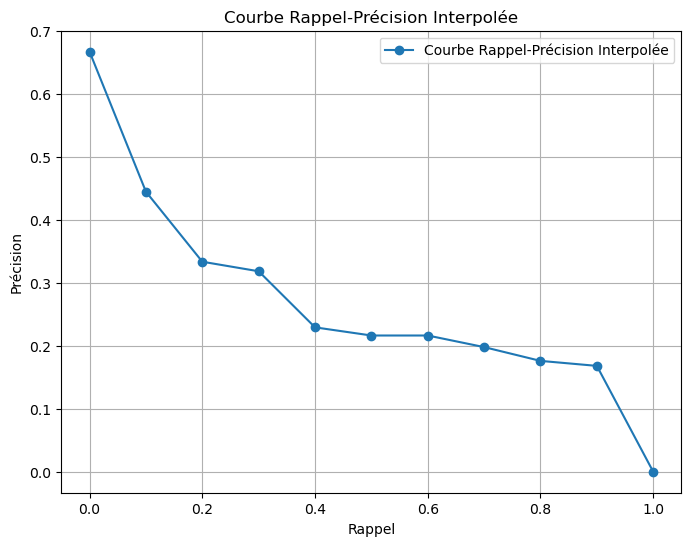

Précision : 0.13291139240506328
Rappel : 0.9130434782608695
F-Score : 0.23204419889502761
P@5 : 0.4
P@10 : 0.4


C:\Users\ryan\AppData\Local\Temp\ipykernel_11216\2952229703.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [31]:
# Exemple d'entrée
numero_request = 4

# Appel de la fonction boolean ou Not_boolean
fig,ax, mesures = evaluation(numero_request, jaccard_relevance ,type='Not_boolean')

# Affichage des mesures
print("Précision :", mesures["precision"])
print("Rappel :", mesures["rappel"])
print("F-Score :", mesures["f_score"])
print("P@5 :", mesures["p_at_5"])
print("P@10 :", mesures["p_at_10"])

# # Affichage de la courbe
fig.show()


## Model Boolean

In [32]:
import os
import re
from collections import defaultdict

# Valider une requête booléenne
def validate_query(query):
    """ Valider une requête booléenne pour une syntaxe appropriée. """
    BOOLEAN_OPERATORS = {"AND", "OR", "NOT"}
    terms = query.split()

    if not terms:
        return False, "La requête ne peut pas être vide."

    if len(terms) == 1:
        if terms[0] not in BOOLEAN_OPERATORS and re.match(r'^\w+$', terms[0]):
            return True, "Requête valide."
        else:
            return False, f"Terme unique non valide : '{terms[0]}'"

    if terms[0] in {"AND", "OR"}:
        return False, "La requête ne peut pas commencer par 'AND' ou 'OR'."

    if terms[-1] in BOOLEAN_OPERATORS:
        return False, "La requête ne peut pas se terminer par un opérateur booléen."

    for i in range(len(terms) - 1):
        if terms[i] not in BOOLEAN_OPERATORS and terms[i + 1] not in BOOLEAN_OPERATORS:
            return False, f"Termes consécutifs non valides : '{terms[i]} {terms[i + 1]}'"
        if terms[i] in {"AND", "OR"} and terms[i + 1] in {"AND", "OR"}:
            return False, f"Séquence non valide après l'opérateur : '{terms[i]} {terms[i + 1]}'"
        if terms[i] == "NOT" and (i + 1 >= len(terms) or terms[i + 1] in BOOLEAN_OPERATORS):
            return False, f"Séquence non valide après 'NOT' : '{terms[i]} {terms[i + 1]}'"

    return True, "Requête valide."

# Évaluer une requête booléenne
def evaluate_boolean_query(query, inverted_index,normalization):
    """ Évaluer une requête booléenne par rapport à l'index inversé avec la priorité des opérateurs : NOT > AND > OR. """
    BOOLEAN_OPERATORS = {"AND", "OR", "NOT"}
    
    terms = query.split()
    terms_preprcessed = []
    for term in query.split():
        if term in BOOLEAN_OPERATORS :
            terms_preprcessed.append(term)
        else :
            terms_preprcessed.append(process_input(term , normalization))
            
    terms = terms_preprcessed
        # 
        # 
        # terms_preprcessed = [process_input(term , normalization) for term in in query.split() if term not in BOOLEAN_OPERATORS ]
    # print(f"term avant {terms_without_process}")
    # terms = []
    # for term in terms_without_process:
    #     if term not in BOOLEAN_OPERATORS:
    #         terms.append(process_input(term , normalization=normalization))
            
    # print(f"term apres {terms_without_process}")
    
    
    
    
    all_docs = set(doc for docs in inverted_index.values() for doc in docs)
    print(all_docs)
    resolve_terms = []

    i = 0
    while i < len(terms):
        term = terms[i]
        if term == "NOT":
            i += 1
            if i < len(terms):
                not_term = terms[i]
                not_set = all_docs - inverted_index.get(not_term, set())
                resolve_terms.append((not_set, "NOT"))
        elif term not in BOOLEAN_OPERATORS:
            term_set = inverted_index.get(term, set())
            resolve_terms.append((term_set, "TERM"))
        else:
            resolve_terms.append((term, "OPERATOR"))
        i += 1

    i = 0
    while i < len(resolve_terms):
        if resolve_terms[i][1] == "OPERATOR" and resolve_terms[i][0] == "AND":
            left = resolve_terms[i - 1][0]
            right = resolve_terms[i + 1][0]
            resolve_terms[i - 1:i + 2] = [(left.intersection(right), "RESOLVED")]
        else:
            i += 1

    i = 0
    while i < len(resolve_terms):
        if resolve_terms[i][1] == "OPERATOR" and resolve_terms[i][0] == "OR":
            left = resolve_terms[i - 1][0]
            right = resolve_terms[i + 1][0]
            resolve_terms[i - 1:i + 2] = [(left.union(right), "RESOLVED")]
        else:
            i += 1

    if resolve_terms and resolve_terms[0][1] == "RESOLVED":
        result_set = resolve_terms[0][0]
        return {doc: doc in result_set for doc in all_docs}
    return {doc: False for doc in all_docs}



def model_booleen(query, tokenization, normalization,output_path="output"):
    _, inverse = open_descripteur_invers(normalization , tokenization ,output_path)
    print(inverse)
    inverted_index = {}

    for keyword, docs in inverse.items():
        inverted_index[keyword] = set(docs.keys())
    
    print(inverted_index)
    
    relevance_scores=evaluate_boolean_query(query, inverted_index,normalization)
    return relevance_scores

query = 'Boundary OR layer AND NOT pressure OR velocity'
valid, message = validate_query(query)
if valid:
    result = model_booleen(query, tokenization='Regex', normalization='Porter',output_path="output")
    print(f"Résultat : {result}")
else:
    print(f"Erreur : {message}")

{'correl': {'D1': {'freq': 4, 'poids': 0.6481}, 'D108': {'freq': 1, 'poids': 0.216}, 'D121': {'freq': 2, 'poids': 0.4321}, 'D148': {'freq': 3, 'poids': 0.3241}, 'D149': {'freq': 1, 'poids': 0.2593}, 'D154': {'freq': 1, 'poids': 0.216}, 'D182': {'freq': 1, 'poids': 0.162}, 'D192': {'freq': 1, 'poids': 0.1852}, 'D205': {'freq': 1, 'poids': 0.1852}, 'D206': {'freq': 1, 'poids': 0.0926}, 'D208': {'freq': 1, 'poids': 0.162}, 'D213': {'freq': 1, 'poids': 0.2593}, 'D247': {'freq': 1, 'poids': 0.2593}, 'D26': {'freq': 1, 'poids': 0.1852}, 'D278': {'freq': 1, 'poids': 0.1852}, 'D29': {'freq': 2, 'poids': 0.2881}, 'D292': {'freq': 1, 'poids': 0.144}, 'D304': {'freq': 2, 'poids': 0.216}, 'D310': {'freq': 2, 'poids': 0.1525}, 'D35': {'freq': 1, 'poids': 0.0926}, 'D386': {'freq': 1, 'poids': 0.3241}, 'D395': {'freq': 1, 'poids': 0.162}, 'D452': {'freq': 1, 'poids': 0.144}, 'D479': {'freq': 1, 'poids': 0.2593}, 'D490': {'freq': 2, 'poids': 0.4321}, 'D581': {'freq': 1, 'poids': 0.0997}, 'D590': {'fre

## Interface

In [33]:

class SearchApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.path = 'Collections'
        self.setWindowTitle("Document Search and Processing")
        self.setGeometry(100, 100, 1170, 800) #8,6 => 900?700 
        self.setWindowIcon(QIcon("./icons/interface_icon.png")) 
        self.setFixedSize(1170, 1200) #900:700
        
        
        # Layout principal
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        self.main_layout = QVBoxLayout(central_widget)
        
        
        # Layout de la barre de recherche
        search_layout = QHBoxLayout()

        
        # Barre de recherche
        self.search_bar = QLineEdit(self)
        self.search_bar.setPlaceholderText("Enter document name...")
        search_layout.addWidget(self.search_bar)

        # Bouton de recherche
        self.search_button = QPushButton("Search", self)
        search_layout.addWidget(self.search_button)

        # Checkbox
        self.checkbox = QCheckBox("Queries Data", self)
        search_layout.addWidget(self.checkbox)

        
        self.number_input = QSpinBox(self)
        self.number_input.setMinimum(0)  # Valeur minimale autorisée
        self.number_input.setMaximum(1000)  # Valeur maximale autorisée
        self.number_input.setValue(0)  # Valeur par défaut
        self.number_input.setPrefix("N° ")  # Ajouter un préfixe si nécessaire
        # self.number_input.setFixedWidth(100)  # Taille fixe pour le champ de saisie (optionnel)
        search_layout.addWidget(self.number_input)

        

        # Ajouter le layout de recherche au layout principal
        self.main_layout.addLayout(search_layout)
        

        # Options de radio
        radio_layout = QHBoxLayout()
        self.raw_text_radio = QRadioButton("Raw Text", self)
        self.processed_text_radio = QRadioButton("Processed Text", self)
        radio_layout.addWidget(self.raw_text_radio)
        radio_layout.addWidget(self.processed_text_radio)
        self.main_layout.addLayout(radio_layout)
        
        # Section Tokenization
        tokenization_box = QGroupBox("Tokenization")
        tokenization_layout = QVBoxLayout()
        self.split_radio = QRadioButton("Split", self)
        self.regex_radio = QRadioButton("Regex", self)
        tokenization_layout.addWidget(self.split_radio)
        tokenization_layout.addWidget(self.regex_radio)
        tokenization_box.setLayout(tokenization_layout)
        
        # Section Normalization
        normalization_box = QGroupBox("Normalization")
        normalization_layout = QVBoxLayout()
        self.no_stem_radio = QRadioButton("No Stem", self)
        self.porter_radio = QRadioButton("Porter", self)
        self.lancaster_radio = QRadioButton("Lancaster", self)
        normalization_layout.addWidget(self.no_stem_radio)
        normalization_layout.addWidget(self.porter_radio)
        normalization_layout.addWidget(self.lancaster_radio)
        normalization_box.setLayout(normalization_layout)
        
        # Section Indexation
        indexation_box = QGroupBox("Indexation")
        indexation_layout = QVBoxLayout()
        self.doc_per_term_radio = QRadioButton("Documents per Term", self)
        self.term_per_doc_radio = QRadioButton("Terms per Document", self)
        indexation_layout.addWidget(self.doc_per_term_radio)
        indexation_layout.addWidget(self.term_per_doc_radio)
        indexation_box.setLayout(indexation_layout)
        
        
        matching_box = QGroupBox("Matching")
        matching_layout = QGridLayout()

        # Boutons radio
        self.vector_space_radio = QRadioButton("Vector Space Model")
        self.probability_model_radio = QRadioButton("Probabilistic Model (BM25)")
        self.boolean_model_radio = QRadioButton("Boolean Model")
        self.data_mining_model_radio = QRadioButton("Data Mining Model")

        # Menu déroulant pour "Vector Space Model"
        self.matching_options = QComboBox()
        self.matching_options.addItems(["Scalar Product", "Cosine Similarity", "Jaccard Index"])

        # Champs de saisie pour k et b sous "Probabilistic Model"
        self.k_input = QLineEdit()
        validator = QDoubleValidator()
        validator.setNotation(QDoubleValidator.StandardNotation)  # Autorise les notations standard (pas scientifiques)
        validator.setRange(-1000.0, 1000.0, 3)  # Plage de valeurs entre -1000 et 1000 avec 3 décimales max
        self.k_input.setValidator(validator)
        self.k_input.setPlaceholderText("K")

        self.b_input = QLineEdit()
        self.b_input.setValidator(validator)  # Utilisez le même validateur pour `b_input`
        self.b_input.setPlaceholderText("B")

        # Ajout des widgets au layout (organisé par colonnes et lignes)
        matching_layout.addWidget(self.vector_space_radio, 0, 0)  # Ligne 0, Colonne 0
        matching_layout.addWidget(self.matching_options, 0, 1)     # Ligne 0, Colonne 1
        matching_layout.addWidget(self.probability_model_radio, 1, 0)  # Ligne 1, Colonne 0
        matching_layout.addWidget(self.k_input, 1, 1)             # Ligne 1, Colonne 1
        matching_layout.addWidget(self.b_input, 1, 2)             # Ligne 1, Colonne 2
        matching_layout.addWidget(self.boolean_model_radio, 2, 0) # Ligne 2, Colonne 0
        matching_layout.addWidget(self.data_mining_model_radio, 3, 0)  # Ligne 3, Colonne 0

        # Appliquer le layout au QGroupBox
        matching_box.setLayout(matching_layout)

        
        # Disposition des sections
        sections_layout = QHBoxLayout()
        sections_layout.addWidget(tokenization_box)
        sections_layout.addWidget(normalization_box)
        sections_layout.addWidget(indexation_box)
        sections_layout.addWidget(matching_box) 
        self.main_layout.addLayout(sections_layout)
        
        # Zone de résultats (QStackedWidget pour alterner entre texte et tableau)
        self.result_label = QLabel("Result: ", self)
        self.main_layout.addWidget(self.result_label)

        self.result_area = QStackedWidget(self)
        self.result_area.setFixedHeight(350)  # Taille fixe pour éviter d'étendre la mise en page
        self.result_area.setFixedWidth(600)  # Ajustez selon la largeur désirée
        
        
        # Widget pour afficher le texte brut
        self.raw_text_widget = QTextEdit(self)
        self.raw_text_widget.setReadOnly(True)  # Rendre le texte en lecture seule
        self.result_area.addWidget(self.raw_text_widget)
        
        # Widget pour afficher le tableau
        self.table = QTableWidget(0, 5, self)  # 5 colonnes pour N°, N° doc, terme, fréquence, poids
        self.table.setHorizontalHeaderLabels(["N°", "N° doc", "Term", "Frequency", "Weight"])
        self.table.setShowGrid(False)  # Masquer la grille du tableau
        
        # Faire en sorte que les colonnes s'étendent pour couvrir toute la largeur
        header = self.table.horizontalHeader()
        header.setSectionResizeMode(QHeaderView.Stretch)
        self.result_area.addWidget(self.table)
        
        self.main_layout.addWidget(self.result_area)

        # evaluation
        # de cote les valeur mersure et l'autre cote pour la figure
        # Layout pour afficher les mesures et le graphe côte à côte
        self.evaluation_layout = QHBoxLayout()
        
        # Zone pour les mesures d'évaluation
        self.mesures_widget = QWidget()
        self.mesures_layout = QVBoxLayout(self.mesures_widget)
        self.mesures_layout.setSpacing(2)
        self.mesures_label = QLabel("Mesures d'évaluation :")
        self.mesures_layout.addWidget(self.mesures_label)
        self.evaluation_layout.addWidget(self.mesures_widget)
        
        # Zone pour afficher le graphe
        self.graph_widget = QWidget()
        self.graph_layout = QVBoxLayout(self.graph_widget)
        # self.figure_canvas = FigureCanvas(None)  # Placeholder pour la figure matplotlib
        self.figure_canvas = FigureCanvas(plt.figure(figsize=(6, 4))) 
        self.graph_layout.addWidget(self.figure_canvas)
        self.evaluation_layout.addWidget(self.graph_widget)
        
        # Ajouter la zone d'évaluation au layout principal
        self.main_layout.addLayout(self.evaluation_layout)






    #    //////////////////////////////////////
        Total_terms_layout = QHBoxLayout()
        
        # Création et configuration des QLabel
        self.terms_per_doc = QLabel(self)
        self.terms_all_doc = QLabel(self)
        
        # Appliquer les styles pour enlever le fond et les bordures
        style = """
            QLabel {
                margin-left: 20px;
                background-color: transparent;
                border: none;
                font-size: 14px;
                font-family: Arial, sans-serif;
            }
        """
        self.terms_all_doc.setStyleSheet(style)
        self.terms_per_doc.setStyleSheet(style)
        
        
        # Ajout des QLabel au layout horizontal
        Total_terms_layout.addWidget(self.terms_per_doc)
        Total_terms_layout.addWidget(self.terms_all_doc)
        
        # Ajout du layout horizontal dans le layout principal
        self.main_layout.addLayout(Total_terms_layout)
        
        
        
        
        # Ajustements dans le code principal
        self.main_layout.setContentsMargins(2, 2, 2, 2)  # Réduire les marges globales
        self.main_layout.setSpacing(8)  # Diminuer l'espace entre les sections
        self.result_area.setContentsMargins(2, 0, 2, 0)  # Marges gauche et droite de 2px pour le tableau
        self.result_area.setFixedWidth(self.width() - 4) 
                
                
        # events
        self.search_button.clicked.connect(self.process_search)
        self.raw_text_radio.clicked.connect(self.raw_text_radio_process)
        self.processed_text_radio.clicked.connect(self.processed_text_radio_process)
        self.vector_space_radio.toggled.connect(self.toggle_radio_buttons)
        
    def toggle_radio_buttons(self,state):
        self.doc_per_term_radio.setEnabled(not state) 
        self.term_per_doc_radio.setEnabled(not state)
        
    def raw_text_radio_process(self):
        self.vector_space_radio.setEnabled(False)
        self.matching_options.setEnabled(False)
        self.split_radio.setEnabled(False) 
        self.regex_radio.setEnabled(False)
        self.lancaster_radio.setEnabled(False)
        self.porter_radio.setEnabled(False)
        self.doc_per_term_radio.setEnabled(False)
        self.term_per_doc_radio.setEnabled(False)
        self.no_stem_radio.setEnabled(False)
        self.terms_per_doc.setText("")
        self.terms_all_doc.setText("")
       
       
    def processed_text_radio_process(self):
        self.vector_space_radio.setEnabled(True)
        self.matching_options.setEnabled(True)
        self.split_radio.setEnabled(True) 
        self.regex_radio.setEnabled(True)
        self.lancaster_radio.setEnabled(True)
        self.porter_radio.setEnabled(True)
        self.doc_per_term_radio.setEnabled(True)
        self.term_per_doc_radio.setEnabled(True)
        self.no_stem_radio.setEnabled(True)
        
         
    def display_Total_Terms(self, termes_global, nb_termes ,index):
        if nb_termes != 0 and index == 'TPD':
            # Afficher le nombre de termes par document
            self.terms_per_doc.setText(f"Terms per document : {nb_termes}")
        else :
            self.terms_per_doc.setText("")
        self.terms_all_doc.setText(f"Total terms  : {termes_global}")

        
        
    def process_search(self):
        # Obtenir le numéro de document
        document_number = self.search_bar.text()
        
        if not document_number:
            self.show_error("Veuillez entrer un numéro de document valide.")
            return

        # 
        # Vérifier le type de texte sélectionné
        if self.raw_text_radio.isChecked():
            # verification de nom_document
            result = get_text(document_number)
            self.show_raw_text(result)
        
        else:
            # Obtenir les méthodes sélectionnées
            tokenization_method = "Split" if self.split_radio.isChecked() else "Regex"
            if self.porter_radio.isChecked() :
                normalization_method = "Porter" 
            elif self.no_stem_radio.isChecked():
                normalization_method = "None" 
            else :
                normalization_method ="Lancaster"
            indexation_method = "DPT" if self.doc_per_term_radio.isChecked() else "TPD"
            if self.checkbox.isChecked():
                # print("Checkbox cochée")
                query_value = self.number_input.value()
                print(f"Valeur de query : {query_value}")

            else:
                print("Checkbox non cochée")
                    
            if self.vector_space_radio.isChecked():
            # Récupération de la méthode de matching sélectionnée
                matching_method = self.matching_options.currentText()
                
                    
                
                if matching_method == "Scalar Product":
                    # print("produit scalaire")
                    relevances = calculer_relevance(document_number, tokenization_method, normalization_method, 'DPT',self.path)
                    # print(relevances)
                    

                elif matching_method == "Cosine Similarity":
                    # print("produit cosine")
                    relevances = calculer_relevance_cosinus(document_number, tokenization_method, normalization_method, 'DPT',self.path)
                    # print(relevances)
                    

                elif matching_method == "Jaccard Index":
                    # print("jacard")
                    relevances = calculer_jaccard_similarity(document_number, tokenization_method, normalization_method, 'DPT',self.path)
                    # print(relevances)
                
                filtered_relevances = {doc: score for doc, score in relevances.items() if score > 0}
                sorted_relevances = sorted(filtered_relevances.items(), key=lambda item: item[1], reverse=True)
                print(sorted_relevances)
                if query_value:
                    fig,ax, mesures = evaluation(query_value, sorted_relevances ,type='Not_boolean')
                    self.display_figure_mesures(fig, mesures)
                
                # Afficher les relevances triées
                self.display_relevance(sorted_relevances)
            elif self.probability_model_radio.isChecked():
                try:
                    text = self.k_input.text()
                    corrected_text_k = text.replace(",", ".")
                    text = self.b_input.text()
                    corrected_text_b = text.replace(",", ".")
                    k = float(corrected_text_k)  # Convertit en flottant
                    b = float(corrected_text_b)
                except ValueError:
                    QMessageBox.warning(self, "Invalid Input", "Please enter valid numeric values for k and b.")
                    k = 1.5  # Valeur par défaut si erreur
                    b = 0.75  # Valeur par défaut si erreur
                print(k,b)
                relevances = calculer_relevance_BM25(document_number, tokenization_method, normalization_method, self.path ,k ,b,'output')
                # filtered_relevances = {doc: score for doc, score in relevances.items() if score > 0}
                # sorted_relevances = sorted(filtered_relevances.items(), key=lambda item: item[1], reverse=True)
                print("BM25")
                print(relevances)
                relevances = list(relevances.items())
               
                self.display_relevance(relevances)
                if query_value:
                    fig , ax, mesures = evaluation(query_value, sorted_relevances ,type='bm25')
                    self.display_figure_mesures(fig, mesures)
                
            elif self.boolean_model_radio.isChecked():
                try :
                    # print(document_number, tokenization_method, normalization_method)
                    # relevances = model_booleen(document_number, tokenization_method, normalization_method, "DPT", self.path,output_path="output")
                    # self.display_relevance(relevances)
                    valid, message = validate_query(query)
                    if valid:
                        relevances = model_booleen(document_number, tokenization_method, normalization_method,output_path="output")
                        print(f"Résultat : {relevances}")
                        relevances = list(relevances.items())
                        self.display_relevance(relevances)
                        if query_value:
                            fig , ax, mesures = evaluation(query_value, sorted_relevances ,type='boolean')
                            self.display_figure_mesures(fig, mesures)
                
                    else:
                        QMessageBox.warning(self, "Invalid Input", f"{message}. Please enter valid Expression.")

                except Exception as e :
                    print(e)
                    QMessageBox.warning(self, "Invalid Input", "Please enter valid Expression.")
                    
            else :
                # termes_global = nb_termes_glob(tokenization_method, normalization_method)
                # Appeler la fonction pour obtenir les données
                data , nb_termes , termes_global=processing(document_number, tokenization_method,  normalization_method, path=path, output_path="output",methode = indexation_method)
                self.display_results(data)
                self.display_Total_Terms(termes_global , nb_termes , indexation_method)
                
                     

    def reset_table(self, column_headers):
        """
        Réinitialise complètement le tableau avec de nouvelles colonnes et leurs en-têtes.

        Parameters:
            column_headers (list of str): Liste des noms des colonnes.
        """
        self.table.clear()  # Efface tout le contenu (cellules et en-têtes)
        self.table.setRowCount(0)  # Réinitialise le nombre de lignes
        self.table.setColumnCount(len(column_headers))  # Définir le nombre de colonnes
        self.table.setHorizontalHeaderLabels(column_headers)  # Définir les en-têtes de colonnes

        # Ajuster les colonnes pour s'étendre uniformément
        header = self.table.horizontalHeader()
        header.setSectionResizeMode(QHeaderView.Stretch)


    def show_raw_text(self, text):
        self.raw_text_widget.setText(text)
        self.result_area.setCurrentWidget(self.raw_text_widget)  # Afficher le widget de texte brut

        
    def display_results(self, data):
    # Supprimer l'affichage de l'index de ligne
        self.table.verticalHeader().setVisible(False)
        # Réinitialiser le tableau avec les colonnes spécifiques
        column_headers = ["N°", "N° doc", "Term", "Frequency", "Weight"]
        self.reset_table(column_headers)
        
        # Nettoyer le tableau et ajouter les résultats
        self.table.setRowCount(0)
        for index, row_data in enumerate(data):
            row_position = self.table.rowCount()
            self.table.insertRow(row_position)
            for column, value in enumerate(row_data):
                item = QTableWidgetItem(str(value))
                item.setTextAlignment(Qt.AlignCenter)  # Centrer le texte dans chaque cellule
                self.table.setItem(row_position, column, item)
        
        # Afficher le widget de tableau
        self.result_area.setCurrentWidget(self.table)
    


    def display_relevance(self, sorted_relevances):
        """
        Affiche les relevances triées dans le tableau.

        Parameters:
            sorted_relevances (list of tuples): Une liste de tuples (document, score de pertinence).
        """
        # Réinitialiser le tableau avec deux colonnes
        column_headers = ["Document", "Score de Pertinence"]
        self.reset_table(column_headers)

        # Ajouter les données triées dans le tableau
        for doc_id, score in sorted_relevances:
            row_position = self.table.rowCount()
            self.table.insertRow(row_position)

            # Ajouter l'identifiant du document
            doc_item = QTableWidgetItem(doc_id)
            doc_item.setTextAlignment(Qt.AlignCenter)
            self.table.setItem(row_position, 0, doc_item)

            # Ajouter le score de pertinence
            if isinstance(score, bool):
                score_item = QTableWidgetItem("True" if score else "False")
            elif isinstance(score, (int, float)):
                score_item = QTableWidgetItem(f"{score:.4f}")
            else:
                raise ValueError(f"Type non pris en charge : {type(score)}")

            score_item.setTextAlignment(Qt.AlignCenter)
            self.table.setItem(row_position, 1, score_item)

        # Afficher le tableau
        self.result_area.setCurrentWidget(self.table)

        
    def display_figure_mesures(self, fig, mesures):
        """
        Affiche les mesures d'évaluation et le graphe dans l'interface.
        
        Arguments :
        - fig : figure matplotlib à afficher.
        - mesures : dictionnaire contenant les mesures d'évaluation.
        """
        # 1. Afficher les mesures
        for i in reversed(range(self.mesures_layout.count())):
            widget_to_remove = self.mesures_layout.itemAt(i).widget()
            if widget_to_remove:
                self.mesures_layout.removeWidget(widget_to_remove)
                widget_to_remove.deleteLater()
        
        self.mesures_layout.addWidget(QLabel("Mesures d'évaluation :"))
        for key, value in mesures.items():
            mesure_label = QLabel(f"{key}: {value:.4f}")
            self.mesures_layout.addWidget(mesure_label)
    
        # 2. Afficher le graphe
        self.graph_layout.removeWidget(self.figure_canvas)
        self.figure_canvas.deleteLater()
        self.figure_canvas = FigureCanvas(fig)
        self.graph_layout.addWidget(self.figure_canvas)
        self.figure_canvas.draw()

        
        
    def show_error(self, message):
        error_dialog = QMessageBox(self)
        error_dialog.setIcon(QMessageBox.Critical)
        error_dialog.setWindowTitle("Erreur")
        error_dialog.setText(message)
        error_dialog.exec_()


In [ ]:
if __name__ == "__main__":
    app = QApplication(sys.argv)
    app.setStyleSheet("""
    QMainWindow {
        background-color: #f5f5f5;
    }
    QLabel {
        color: #333333;
        font-size: 14px;
    }
    QLineEdit {
        border: 1px solid #CCCCCC;
        border-radius: 5px;
        padding: 5px;
    }
    QPushButton {
        background-color: #4CAF50;
        color: white;
        font-size: 14px;
        padding: 5px 10px;
        border-radius: 5px;
    }
    QPushButton:hover {
        background-color: #45a049;
    }
    
    QRadioButton {
        font-size: 13px;
    }
    QGroupBox {
        font-size: 15px;
        color: #333333;
        border: 1px solid #CCCCCC;
        border-radius: 8px;
        margin-top: 10px;
        padding: 10px;
    }
    QTextEdit {
        background-color: #f0f0f0;
        border: 1px solid #CCCCCC;
        border-radius: 5px;
        padding: 5px;
    }
    QTableWidget {
        background-color: #FFFFFF;
        border: 1px solid #CCCCCC;
        border-radius: 5px;
        padding: 2px;
        gridline-color: #E0E0E0;
    }
    QTableWidget::item {
        padding: 5px;
        border-bottom: 1px solid #E0E0E0;
    }
    QHeaderView::section {
        background-color: #f0f0f0;
        padding: 5px;
        border: 1px solid #CCCCCC;
        font-weight: bold;
    }

    QLabel {
        margin-left: 20px;
        background-color: transparent;
        border: none;
        font-size: 14px;
        font-family: Arial, sans-serif;
    }
    
""")

    window = SearchApp()
    window.show()
    sys.exit(app.exec_())


Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'

Valeur de query : 4


KeyError: 'D1008'